### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMClassifier

plt.rcParams['figure.figsize'] = (10,10)
pd.set_option("display.max_columns", 100)

%matplotlib inline

### Loading Training and Testing data

In [2]:
account_seg = pd.read_csv("raw_account_70_new.csv")
enquiry_seg = pd.read_csv("raw_enquiry_70_new.csv")
current_data = pd.read_csv("raw_data_70_new.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
account_seg_te = pd.read_csv("raw_account_30_new.csv")
enquiry_seg_te = pd.read_csv("raw_enquiry_30_new.csv")
current_data_te = pd.read_csv("raw_data_30_new.csv")

### Data Preprocessing

In [4]:
missing_cols = []
for col in current_data.columns:
    threshold = 23896 * 0.3
    if current_data[col].isnull().sum() > threshold:
        missing_cols.append(col)

In [5]:
unimp_cols = ["feature_20", "feature_22", "feature_77", 'feature_75', 'feature_70', "feature_47", 'feature_16', "feature_38", "feature_28", "feature_63", "feature_15"]
for col in current_data.columns:
    if current_data[col].nunique()==1:
        unimp_cols.append(col)

In [6]:
def get_email_provider(provider):
    try:
        temp = provider[1:].lower().split(".")[0]
        if "dif" in temp:
            return "rediffmail"
        elif "gmai" in temp:
            return "gmail"
        else:
            return temp
    except:
        return -999

In [7]:
def preprocess_data(current_data):
    train_df = current_data[current_data.columns.drop(missing_cols)]

    train_df = train_df[train_df.columns.drop(unimp_cols)]

    train_df['feature_24'] = train_df.feature_24.apply(lambda row: get_email_provider(row)) 

    map_yn = {"Y":1, "N":0}
    map_ro = {"R":0, "O":1}
    yn_col = ["feature_79","feature_62", "feature_60", "feature_59","feature_58","feature_50","feature_33","feature_23","feature_11"]
    for col in yn_col:
        train_df[col+"_enc"] = train_df[col].map(map_yn)
        train_df = train_df.drop(col, axis=1)

    train_df["feature_72_enc"] = train_df['feature_72'].map(map_ro)
    train_df = train_df.drop("feature_72", axis=1)

    enc_cols = ['feature_1', 'feature_12', 'feature_24', 'feature_32', 'feature_36', 'feature_37', 'feature_43', 'feature_46', 'feature_27']
    for col in enc_cols:
        temp = pd.DataFrame()
        temp[col] = train_df[col].unique()
        temp[col+"_enc"] = range(len(temp))
        train_df = train_df.merge(temp, on=col, how='left')
        train_df = train_df.drop(col, axis=1)

    train_df['dt_opened'] = pd.to_datetime(train_df['dt_opened'], format="%d-%b-%y")

    train_df['entry_time'] = pd.to_datetime(train_df['entry_time'], format="%d-%b-%y")

    train_df['feature_2'] = pd.to_datetime(train_df['feature_2'], format="%d-%b-%y")

    train_df['feature_21'] = pd.to_datetime(train_df['feature_21'], format="%d-%b-%y")

    train_df['dt_opened_entry'] = train_df.apply(lambda row: (row['dt_opened'] - row['entry_time']).days, axis=1)

    train_df['dt_opened_feat_2'] = train_df.apply(lambda row: (row['dt_opened'] - row['feature_2']).days, axis=1)

    train_df['dt_entry_time_feat_2'] = train_df.apply(lambda row: (row['entry_time'] - row['feature_2']).days, axis=1)

    train_df['dt_opened_feat_21'] = train_df.apply(lambda row: (row['dt_opened'].year - row['feature_21'].year), axis=1)

    train_df['dt_opened_feat_30'] = train_df.apply(lambda row: (row['dt_opened'].year - row['feature_30']), axis=1)
    
    return train_df

In [8]:
train_df = preprocess_data(current_data)
test_df = preprocess_data(current_data_te)

### Feature Engineering

In [9]:
def create_account_seg_feats(account_seg, train_df):
    mean_cur_balance = account_seg.groupby(by='customer_no', as_index=False)['cur_balance_amt'].mean()

    mean_credit_lim = account_seg.groupby(by='customer_no', as_index=False)[['creditlimit', 'cashlimit']].mean()

    total_cur_balance = account_seg.groupby(by='customer_no', as_index=False)['cur_balance_amt'].sum()
    total_credit_lim = account_seg.groupby(by='customer_no', as_index=False)[['creditlimit', 'cashlimit']].sum()

    mean_credit_lim['mean_total_credit'] = mean_credit_lim['creditlimit'] + mean_credit_lim['cashlimit']
    mean_credit_lim['ratio_mean_balance_credit'] = mean_cur_balance['cur_balance_amt']/mean_credit_lim['mean_total_credit']

    total_credit_lim['total_credit'] = total_credit_lim['creditlimit'] + total_credit_lim['cashlimit']
    total_credit_lim['utilisation_trend'] = (total_cur_balance['cur_balance_amt']/total_credit_lim['total_credit'])/(mean_cur_balance['cur_balance_amt']/mean_credit_lim['mean_total_credit'])

    account_seg['dt_opened'] = pd.to_datetime(account_seg['dt_opened'], format="%d-%b-%y")
    account_seg['upload_dt'] = pd.to_datetime(account_seg['upload_dt'], format="%d-%b-%y")
    account_seg['opened_dt'] = pd.to_datetime(account_seg['opened_dt'], format="%d-%b-%y")
    account_seg['last_paymt_dt'] = pd.to_datetime(account_seg['last_paymt_dt'], format="%d-%b-%y")
    account_seg['reporting_dt'] = pd.to_datetime(account_seg['reporting_dt'], format="%d-%b-%y")
    account_seg['closed_dt'] = pd.to_datetime(account_seg['closed_dt'], format="%d-%b-%y")
    account_seg['paymt_str_dt'] = pd.to_datetime(account_seg['paymt_str_dt'], format="%d-%b-%y")
    account_seg['paymt_end_dt'] = pd.to_datetime(account_seg['paymt_end_dt'], format="%d-%b-%y")

    n_accounts = account_seg.groupby(by='customer_no', as_index=False)['acct_type'].count().rename(columns={"acct_type": "no_accounts"})

    account_seg['len_payment_hist'] = account_seg.paymenthistory1.str.len()

    mean_payment_hist = account_seg.groupby(by='customer_no', as_index=False)['len_payment_hist'].mean()

    n_acc_types = account_seg.groupby(by='customer_no')['acct_type'].nunique().reset_index().rename(columns={"acct_type": "unique_acct_types"})

    zero_cur_balance = pd.DataFrame()
    zero_cur_balance['customer_no'] = account_seg.customer_no.unique()
    temp_bal = account_seg[account_seg['cur_balance_amt'] <= 0].groupby(by='customer_no', as_index=False)['acct_type'].count().rename(columns={"acct_type": "zero_cur_balance"})
    zero_cur_balance = zero_cur_balance.merge(temp_bal, on='customer_no', how='left')
    zero_cur_balance.fillna(0, inplace=True)
    
    train_df = train_df.merge(mean_credit_lim[['customer_no', 'ratio_mean_balance_credit']], on='customer_no', how='left')
    train_df = train_df.merge(total_credit_lim[['customer_no', 'utilisation_trend']], on='customer_no', how='left')
    train_df = train_df.merge(n_acc_types, on='customer_no', how='left')
    train_df = train_df.merge(n_accounts, on='customer_no', how='left')
    train_df = train_df.merge(mean_payment_hist, on='customer_no', how='left')
    train_df = train_df.merge(zero_cur_balance, on='customer_no', how='left')
    
    return train_df
    

In [10]:
def create_enq_feats(enquiry_seg, train_df):
    n_enq = enquiry_seg.groupby(by='customer_no', as_index=False)['enq_purpose'].count().rename(columns={"enq_purpose": "n_enquiries"})
    unique_enq = enquiry_seg.groupby(by='customer_no')['enq_purpose'].nunique().reset_index().rename(columns={"enq_purpose": "unique_enq"})
    mean_enq_amt=enquiry_seg.groupby(by='customer_no', as_index=False)['enq_amt'].mean().rename(columns={"enq_amt": "mean_enq_amt"})
    enquiry_seg['enquiry_dt'] = pd.to_datetime(enquiry_seg['enquiry_dt'], format="%d-%b-%y")
    enquiry_seg['enquiry_dt_shift'] = enquiry_seg.enquiry_dt.shift(1)
    enquiry_seg['time_bw_cons_enq'] = (enquiry_seg['enquiry_dt'] - enquiry_seg['enquiry_dt_shift'])/pd.np.timedelta64("1", "D")
    time_bw_enq = enquiry_seg.groupby(by='customer_no', as_index=False)['time_bw_cons_enq'].median()
    latest_enq = enquiry_seg.groupby(by='customer_no', as_index=False)[['enquiry_dt']].max()
    
    train_df = train_df.merge(n_enq, on='customer_no', how='left')
    train_df = train_df.merge(unique_enq, on='customer_no', how='left')
    train_df = train_df.merge(mean_enq_amt, on='customer_no', how='left')
    train_df = train_df.merge(time_bw_enq, on='customer_no', how='left')
    train_df = train_df.merge(latest_enq, on='customer_no', how='left')
    train_df['latest_enq_opened'] = (train_df['dt_opened'] - train_df['enquiry_dt'])/pd.np.timedelta64("1", "D")
    
    return train_df

In [11]:
train_df = create_account_seg_feats(account_seg, train_df)
test_df = create_account_seg_feats(account_seg_te, test_df)

In [12]:
train_df = create_enq_feats(enquiry_seg, train_df)
test_df = create_enq_feats(enquiry_seg_te, test_df)

### Modelling

In [13]:
train_df.head()

,dt_opened,customer_no,entry_time,feature_2,feature_3,feature_4,feature_7,feature_19,feature_21,feature_25,feature_26,feature_29,feature_30,feature_31,feature_34,feature_35,feature_39,feature_40,feature_41,feature_42,feature_44,feature_52,feature_55,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_76,feature_78,Bad_label,feature_79_enc,feature_62_enc,feature_60_enc,feature_59_enc,feature_58_enc,feature_50_enc,feature_33_enc,feature_23_enc,feature_11_enc,feature_72_enc,feature_1_enc,feature_12_enc,feature_24_enc,feature_32_enc,feature_36_enc,feature_37_enc,feature_43_enc,feature_46_enc,feature_27_enc,dt_opened_entry,dt_opened_feat_2,dt_entry_time_feat_2,dt_opened_feat_21,dt_opened_feat_30,ratio_mean_balance_credit,utilisation_trend,unique_acct_types,no_accounts,len_payment_hist,zero_cur_balance,n_enquiries,unique_enq,mean_enq_amt,time_bw_cons_enq,enquiry_dt,latest_enq_opened
0,2015-04-18,1,2015-04-13,2015-04-13,650.0,2.0,500000.0,1.0,2065-09-03,1.0,2.0,400610.0,1965.0,0.0,2.0,90000.0,0.0,0.0,0.0,0.0,400059.0,0.0,1.0,21.0,21.0,15.0,400610.0,0.0,2.0,90000.0,21.0,0.0,1.0,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,5.0,5.0,0.0,-50.0,50.0,0.520749,10.804296,4,18,34.166667,12.0,18,4,2.767306e+05,-123.0,2014-12-19,120.0
1,2015-04-21,2,2015-04-21,2015-04-21,760.0,1.0,1200000.0,1.0,2062-07-14,1.0,2.0,560042.0,1969.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,560042.0,0.0,1.0,17.0,17.0,12.0,560042.0,0.0,2.0,1.0,17.0,0.0,1.0,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,-47.0,46.0,0.015377,2.000000,1,2,60.000000,0.0,68,9,9.818650e+07,-15.0,2015-02-11,69.0
2,2015-04-22,3,2015-04-21,2015-04-21,774.0,1.0,700000.0,2.0,2066-04-10,1.0,0.0,560042.0,1966.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,560042.0,0.0,3.0,17.0,17.0,12.0,560042.0,0.0,2.0,1.0,17.0,0.0,1.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,2,0,0,0,1,0,0,1.0,1.0,0.0,-51.0,49.0,NaN,NaN,1,1,60.000000,0.0,1,1,3.400000e+06,2626.0,2014-02-08,438.0
3,2015-04-25,4,2015-04-15,2015-04-20,770.0,1.0,500000.0,1.0,2064-04-16,1.0,3.0,411001.0,1988.0,0.0,2.0,100000.0,0.0,0.0,0.0,0.0,411026.0,0.0,1.0,21.0,21.0,16.0,411001.0,0.0,2.0,100000.0,21.0,1.0,1.0,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,3,0,0,0,2,0,0,10.0,5.0,-5.0,-49.0,27.0,0.247296,5.666667,5,17,43.764706,14.0,34,5,1.494412e+06,-14.5,2014-03-03,418.0
4,2015-05-06,5,2015-04-30,NaT,NaN,3.0,500000.0,1.0,2054-01-03,1.0,3.0,122009.0,1995.0,0.0,2.0,300000.0,0.0,0.0,0.0,0.0,122009.0,0.0,1.0,13.0,13.0,3.0,122009.0,0.0,2.0,300000.0,13.0,0.0,1.0,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,3,0,0,6.0,NaN,NaN,-39.0,20.0,NaN,NaN,2,7,44.142857,6.0,2,1,1.000000e+03,496.0,2012-03-28,1134.0


In [14]:
test_df.head()

,dt_opened,customer_no,entry_time,feature_2,feature_3,feature_4,feature_7,feature_19,feature_21,feature_25,feature_26,feature_29,feature_30,feature_31,feature_34,feature_35,feature_39,feature_40,feature_41,feature_42,feature_44,feature_52,feature_55,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_76,feature_78,Bad_label,feature_79_enc,feature_62_enc,feature_60_enc,feature_59_enc,feature_58_enc,feature_50_enc,feature_33_enc,feature_23_enc,feature_11_enc,feature_72_enc,feature_1_enc,feature_12_enc,feature_24_enc,feature_32_enc,feature_36_enc,feature_37_enc,feature_43_enc,feature_46_enc,feature_27_enc,dt_opened_entry,dt_opened_feat_2,dt_entry_time_feat_2,dt_opened_feat_21,dt_opened_feat_30,ratio_mean_balance_credit,utilisation_trend,unique_acct_types,no_accounts,len_payment_hist,zero_cur_balance,n_enquiries,unique_enq,mean_enq_amt,time_bw_cons_enq,enquiry_dt,latest_enq_opened
0,2015-04-21,1,2015-04-17,2015-04-17,726.0,1.0,1200000.0,2.0,2059-09-09,1.0,3.0,411036.0,1999.0,0.0,1.0,200000.0,1999.0,0.0,11.0,0.0,411001.0,0.0,3.0,21.0,21.0,16.0,411036.0,0.0,1.0,200000.0,21.0,0.0,1.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,4.0,4.0,0.0,-44.0,16.0,8.331880,3.266302,5,16,47.0625,10.0,33,7,6.098218e+07,-49.0,2014-11-10,162.0
1,2015-05-12,2,2015-05-06,2015-05-06,844.0,1.0,300000.0,2.0,2051-10-02,1.0,0.0,700019.0,1964.0,0.0,2.0,70000.0,0.0,0.0,0.0,0.0,700019.0,0.0,3.0,35.0,35.0,58.0,700019.0,0.0,2.0,70000.0,35.0,0.0,1.0,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,1,0,1,1,1,1,0,6.0,6.0,0.0,-36.0,51.0,NaN,NaN,1,1,60.0000,1.0,2,1,2.550000e+04,966.0,2012-02-28,1169.0
2,2015-05-21,3,2015-05-20,2015-05-20,723.0,3.0,1500000.0,1.0,1970-04-02,1.0,0.0,110017.0,1970.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,110017.0,0.0,1.0,10.0,10.0,157.0,110017.0,0.0,2.0,1.0,10.0,0.0,1.0,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0,1,2,0,1,1,2,1,0,1.0,1.0,0.0,45.0,45.0,2.320426,5.500000,2,11,54.0000,7.0,17,4,1.179625e+07,-130.0,2015-04-13,38.0
3,2015-05-22,4,2015-05-22,2015-05-22,778.0,1.0,2500000.0,1.0,1974-12-24,1.0,3.0,110062.0,1974.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,110044.0,0.0,1.0,10.0,10.0,157.0,110062.0,0.0,2.0,1.0,10.0,0.0,1.0,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0,1,3,0,1,1,2,0,0,0.0,0.0,0.0,41.0,41.0,0.286877,6.250000,7,25,45.2400,18.0,50,7,2.542756e+07,-5.0,2014-07-28,298.0
4,2015-05-22,5,2015-05-12,2015-05-13,810.0,1.0,500000.0,1.0,2051-09-12,1.0,1.0,400018.0,2000.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,400034.0,0.0,1.0,21.0,21.0,15.0,400018.0,0.0,2.0,1.0,21.0,1.0,2.0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,1,0,1,1,3,1,0,10.0,9.0,-1.0,-36.0,15.0,0.025103,3.000000,1,6,51.5000,4.0,5,4,2.240400e+06,-117.0,2014-11-17,186.0


In [15]:
train_df.fillna(-999, inplace=True)

In [16]:
test_df.fillna(-999, inplace=True)

In [17]:
top_feats = ['feature_3',
 'mean_enq_amt',
 'feature_7',
 'no_accounts',
 'len_payment_hist',
 'feature_52',
 'ratio_mean_balance_credit',
 'utilisation_trend',
 'dt_opened_feat_2',
 'feature_66', 'Bad_label', 'latest_enq_opened']

In [18]:
xgbc = xgb.XGBClassifier(max_depth=3, missing=-999, silent=False, n_estimators=1200, learning_rate=0.001, seed=123, colsample_bytree=0.3)

In [78]:
X_train = train_df[top_feats]
X_test = test_df[top_feats]
ens_df = pd.DataFrame()
ens_df_tr = pd.DataFrame()
for i in range(55):
    print "\tDone: ",i
    temp_1 = X_train[X_train["Bad_label"] == 1]
    temp_0 = X_train[X_train['Bad_label'] == 0]
    temp = pd.concat([temp_1, temp_0.sample(n=len(temp_1), random_state=i)])
    xgbc.fit(temp.drop('Bad_label', axis=1), temp['Bad_label'])
    preds = xgbc.predict_proba(X_test.drop("Bad_label", axis=1))
    preds_tr = xgbc.predict_proba(X_train.drop("Bad_label", axis=1))
    ens_df['model_'+str(i)] = preds[:,1]
    ens_df_tr['model_'+str(i)] = preds_tr[:,1]
    ens_df['mean_prob'] = ens_df.mean(axis=1)
    ens_df_tr['mean_prob'] = ens_df_tr.mean(axis=1)
print "GINI: ",2*roc_auc_score(X_test['Bad_label'], ens_df['mean_prob'])-1

	Done:  0
	Done:  1
	Done:  2
	Done:  3
	Done:  4
	Done:  5
	Done:  6
	Done:  7
	Done:  8
	Done:  9
	Done:  10
	Done:  11
	Done:  12
	Done:  13
	Done:  14
	Done:  15
	Done:  16
	Done:  17
	Done:  18
	Done:  19
	Done:  20
	Done:  21
	Done:  22
	Done:  23
	Done:  24
	Done:  25
	Done:  26
	Done:  27
	Done:  28
	Done:  29
	Done:  30
	Done:  31
	Done:  32
	Done:  33
	Done:  34
	Done:  35
	Done:  36
	Done:  37
	Done:  38
	Done:  39
	Done:  40
	Done:  41
	Done:  42
	Done:  43
	Done:  44
	Done:  45
	Done:  46
	Done:  47
	Done:  48
	Done:  49
	Done:  50
	Done:  51
	Done:  52
	Done:  53
	Done:  54
GINI:  0.31098702892525787


In [79]:
test_df['prob'] = ens_df['mean_prob']

In [81]:
test_df = test_df.sort_values(by='prob', ascending=False)
test_df = test_df.reset_index(drop=True)

In [98]:
gain_df = pd.DataFrame()
gain_df['decile'] = range(10, 0, -1)
gain_df['percent of positives'] = 0
k = 0
for i in range(10):
    gain_df.loc[i, 'percent of positives'] = test_df.loc[k: k+1024, 'Bad_label'].mean()
    k += 1024

In [99]:
gain_df

,decile,percent of positives
0,10,0.089756
1,9,0.068293
2,8,0.065366
3,7,0.050732
4,6,0.047805
5,5,0.039024
6,4,0.034146
7,3,0.021463
8,2,0.018537
9,1,0.016602


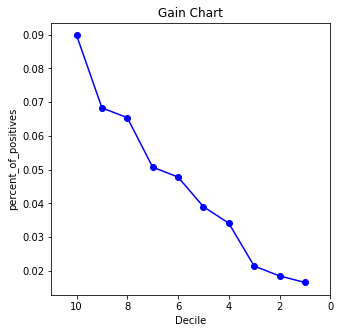

In [108]:
plt.plot(gain_df['decile'], gain_df['percent of positives'], 'b-o')
plt.xlim((11,0))
plt.xlabel("Decile")
plt.ylabel("percent_of_positives")
plt.title("Gain Chart")

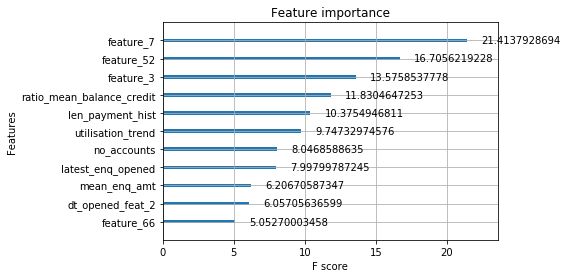

In [22]:
xgb.plot_importance(xgbc, importance_type='gain')

### Cross Validation

In [19]:
kf = KFold(n_splits=3, random_state=123)

counter = 1
test_ginis = []
train_ginis = []
for train, test in kf.split(train_df[top_feats], train_df['Bad_label']):
    print "CV: ", counter
    X_train = train_df[top_feats].loc[train]
    X_test = train_df[top_feats].loc[test]
    ens_df = pd.DataFrame()
    ens_df_tr = pd.DataFrame()
    for i in range(10):
        print "\tDone: ",i
        temp_1 = X_train[X_train["Bad_label"] == 1]
        temp_0 = X_train[X_train['Bad_label'] == 0]
        temp = pd.concat([temp_1, temp_0.sample(n=len(temp_1), random_state=i)])
        xgbc.fit(temp.drop('Bad_label', axis=1), temp['Bad_label'])
        preds = xgbc.predict_proba(X_test.drop("Bad_label", axis=1))
        preds_tr = xgbc.predict_proba(X_train.drop("Bad_label", axis=1))
        ens_df['model_'+str(i)] = preds[:,1]
        ens_df_tr['model_'+str(i)] = preds_tr[:,1]
        ens_df['mean_prob'] = ens_df.mean(axis=1)
        ens_df_tr['mean_prob'] = ens_df_tr.mean(axis=1)
    print "GINI: ",2*roc_auc_score(X_test['Bad_label'], ens_df['mean_prob'])-1
    test_ginis.append(2*roc_auc_score(X_test['Bad_label'], ens_df['mean_prob'])-1)
    print "GINI train: ", 2*roc_auc_score(X_train['Bad_label'], ens_df_tr['mean_prob'])-1
    train_ginis.append(2*roc_auc_score(X_train['Bad_label'], ens_df_tr['mean_prob'])-1)
    counter += 1
print "Avg test GINI: ", pd.np.mean(test_ginis)
print "Avg train GINI: ", pd.np.mean(train_ginis)